In [1]:
# imports
import numpy as np

import matplotlib
import pylab as pl

%matplotlib inline 
%qtconsole

# Gene expression in single cells is stochastic

## The two state promoter model

**Some literature:**
1. Raj, A., Peskin, C. S., Tranchina, D., Vargas, D. Y. & Tyagi, S. Stochastic mRNA synthesis in mammalian cells. PLoS Biol. 4, e309 (2006).
2. Coulon, A., Chow, C. C., Singer, R. H. & Larson, D. R. Eukaryotic transcriptional dynamics: from single molecules to cell populations. Nat. Rev. Genet. 14, 572–84 (2013).

# Stochastic simulations to model stochastic gene expression

## Reactions

Gene switching $$ On \xrightarrow{k_{off}} Off$$
$$ On \xleftarrow{k_{on}} Off$$
RNA transcription, when the gene is on
$$ RNA \xrightarrow{k_{txn}} RNA + 1 $$
RNA degradation
$$ RNA \xrightarrow{\gamma_{RNA}\cdot RNA} RNA -1$$
Protein production
$$ protein \xrightarrow{k_{tl}*RNA} protein + 1$$
Protein degradation
$$protein \xrightarrow{\gamma_{protein} \cdot protein} protein -1$$

## SSA or Gillespie algorithm

**Some literature**

1. Gillespie, D. T. A rigorous derivation of the chemical master equation. Phys. A Stat. Mech. its Appl. 188, 404–425 (1992).

2. Gillespie, D. T. Exact stochastic simulation of coupled chemical reactions. J. Phys. Chem. 93555, 2340–2361 (1977).

3. Gillespie, D. T. Stochastic simulation of chemical kinetics. Annu. Rev. Phys. Chem. 58, 35–55 (2007).

In [96]:
# functions
def SSA_simulation(x_0, c, stoich_matrix, t_max):

    state = x_0
    state_path = []
    state_path.append(state)

    time = []
    time.append(0)

    tt = 0
    while tt <= t_max:
        rr = np.random.uniform(0, 1, 2)

        a_s = propensities(c, state)
        cum_a_s = np.cumsum(a_s)
        a_0 = cum_a_s[-1]

        tt = tt + 1.0 / a_0 * np.log(1.0 / rr[0])
        time.append(tt)

        prop = rr[1] * a_0

        ind = np.where(prop < cum_a_s)[0][0]

        state = state + stoich_matrix[ind]
        state_path.append(state)

    return time, np.vstack(state_path)


def propensities(c, state):
    if state[0] == 0:
        return np.array(
            [c[0], 0, 0, c[3] * state[1], c[4] * state[1], c[5] * state[2]])
    else:
        return np.array(
            [0, c[1], c[2], c[3] * state[1], c[4] * state[1], c[5] * state[2]])


def sample_SSApath_grid(ssa_time, ssa_states, time_grid):
    sampled_path = np.zeros((len(time_grid), ssa_states.shape[1]))

    for ii, time in enumerate(time_grid):
        ind = np.where(ssa_time <= time)[0][-1]
        sampled_path[ii] = ssa_states[ind]

    return sampled_path


In [97]:
# initialise
x_0 = np.zeros(3)

c = [
    0.002,  # gene activation rate
    0.005,  # gene inactivation rate
    0.5,  # transcription rate
    0.005,  # RNA degradation rate
    0.1,  # RNA translation rate
    0.0005,  # protein degradation rate
]

stoich_matrix = np.array([[1, 0, 0], 
                          [-1, 0, 0],
                          [0, 1, 0], 
                          [0, -1, 0],
                          [0, 0, 1], 
                          [0, 0, -1]])


In [120]:
# single realisation
time,states = SSA_simulation(x_0,c,stoich_matrix,10000)

Text(0.5, 0, 'RNA copy number')

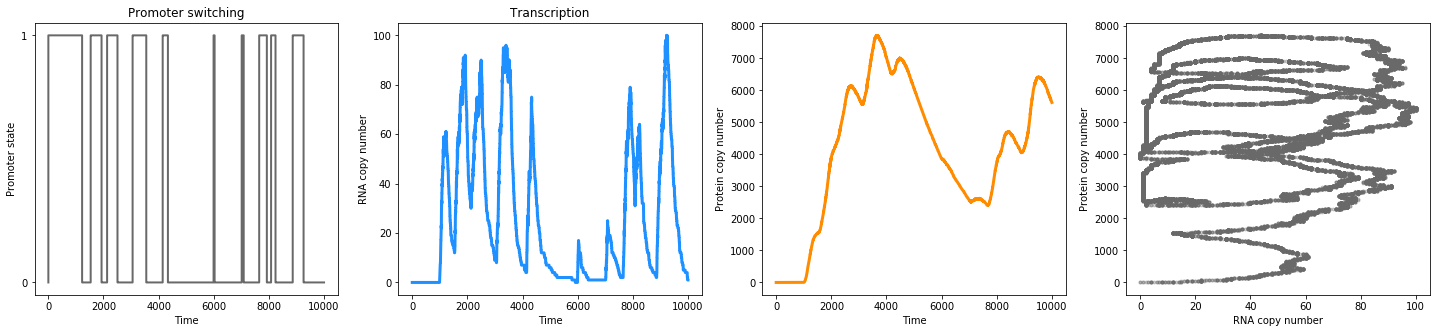

In [122]:
fig,ax = pl.subplots(1,4, figsize = (25,5))

ax[0].plot(time,states[:,0], lw = 2, color = 'dimgrey', drawstyle = 'steps-pre')

ax[0].set_title('Promoter switching')
ax[0].set_xlabel('Time')
ax[0].set_yticks([0,1])
ax[0].set_ylabel('Promoter state')


ax[1].plot(time,states[:,1],lw = 3, color = 'dodgerblue')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('RNA copy number')
ax[1].set_title('Transcription')

ax[2].plot(time,states[:,2], lw = 3, color = 'darkorange')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Protein copy number')

ax[3].plot(states[:,1],states[:,2],'.', color = 'dimgrey', alpha = 0.3)
ax[3].set_ylabel('Protein copy number')
ax[3].set_xlabel('RNA copy number')

# Moment equations

**Some literature**
1. Zechner, C. et al. Moment-based inference predicts bimodality in transient gene expression. Proc. Natl. Acad. Sci. 109, 8340–8345 (2012).

In [123]:
# average over SSA runs to obtain means and variances
repeats = 500
t_max = 5000

time_grid = np.linspace(0,t_max,100)

sims = np.zeros((repeats,len(time_grid),3))

for ii in np.arange(repeats):
    ssa_time,ssa_states = SSA_simulation(x_0,c,stoich_matrix,t_max)
    
    sims[ii] = sample_SSApath_grid(ssa_time,ssa_states,time_grid)

Text(0.5, 0, 'RNA copy number')

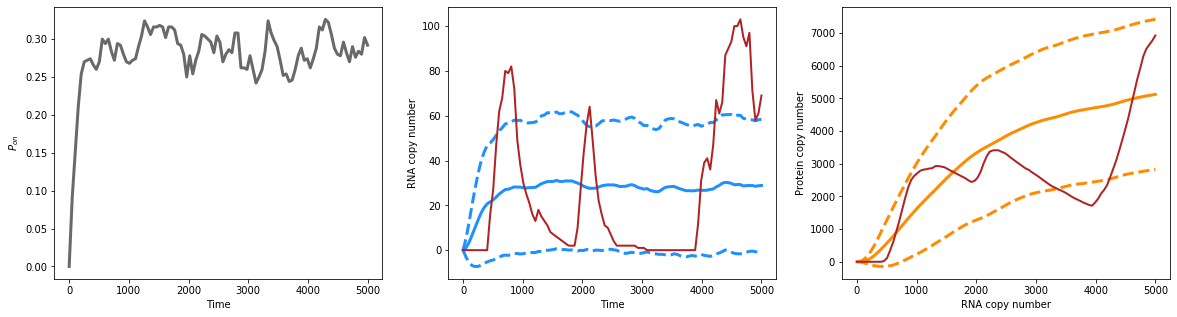

In [125]:
fig,ax = pl.subplots(1,3, figsize = (20,5))

means = sims.mean(0)
stds = sims.std(0)

ax[0].plot(time_grid,means[:,0], lw = 3, color = 'dimgrey')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('$P_{on}$')

ax[1].plot(time_grid,means[:,1], lw = 3, color = 'dodgerblue')
ax[1].plot(time_grid,means[:,1] + stds[:,1],'--', lw = 3, color = 'dodgerblue')
ax[1].plot(time_grid,means[:,1] - stds[:,1],'--', lw = 3, color = 'dodgerblue')
ax[1].plot(time_grid,sims[1,:,1], lw = 2, color = 'firebrick')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('RNA copy number')


ax[2].plot(time_grid,means[:,2], lw = 3, color = 'darkorange')
ax[2].plot(time_grid,means[:,2] + stds[:,2], '--', lw = 3, color = 'darkorange')
ax[2].plot(time_grid,means[:,2] - stds[:,2], '--', lw = 3, color = 'darkorange')
ax[2].plot(time_grid,sims[1,:,2], lw = 2, color = 'firebrick')
ax[2].set_ylabel('Protein copy number')
ax[2].set_xlabel('RNA copy number')